# **Attention-Driven Multi-Class Abnormality Detection in Video Capsule Endoscopy (VCE) Using Enhanced InceptionResNetV2**

## INTRODUCTION

We are building an image classification model for detecting abnormalities from video capsule endoscopy images using a hybrid architecture based on InceptionResNetV2. The model integrates custom CNN layers with attention mechanisms for better feature extraction and classification performance.

## Setup: Import Libraries and Define Paths

In [2]:
# Importing necessary libraries and modules
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Dropout, 
                                     GlobalAveragePooling2D, Input, BatchNormalization, 
                                     Activation, Flatten, Add, Multiply)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils import class_weight
from tensorflow.keras.applications import InceptionResNetV2
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns


## Dataset Preparation

Update the path to your dataset and define the class folders:

In [3]:
# Define the base path to the dataset
base_dir = '/kaggle/input/vce-video-frames/Dataset/'

# Define class folders
classes = [
    'Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 
    'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms'
]

## Data Preprocessing

Using ImageDataGenerator for training and validation data augmentation.

In [4]:
# Parameters
image_size = (299, 299) 
batch_size = 32
epochs = 20

# Create ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Define training and validation directories
training_dir = os.path.join(base_dir, "training")
validation_dir = os.path.join(base_dir, "validation")

# Create generators
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 37607 images belonging to 10 classes.
Found 16132 images belonging to 10 classes.


## Calculating Class Weights

Using class weights to handle class imbalance for better training performance.

In [5]:
# Calculate class weights
y_train_labels = train_generator.classes
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights_dict = dict(enumerate(class_weights))

## Model Architecture: Attention-Enhanced InceptionResNetV2

Building a hybrid model that combines InceptionResNetV2 with custom CNN blocks and attention mechanisms.

In [6]:
# Attention mechanism
def attention_block(inputs):
    x = GlobalAveragePooling2D()(inputs)
    x = Dense(inputs.shape[-1] // 8, activation='relu')(x)
    x = Dense(inputs.shape[-1], activation='sigmoid')(x)
    return Multiply()([inputs, x])

# Building the enhanced hybrid model
def build_enhanced_hybrid_model(input_shape=(299, 299, 3), num_classes=len(classes)):
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    
    # Custom CNN Block 1
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)
    
    # Applying attention after convolution
    x = attention_block(x)

    # Custom CNN Block 2
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)
    
    # Applying attention again
    x = attention_block(x)

    # Final pooling and output layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    
    # Fine-tune some layers of the base model
    for layer in base_model.layers[-20:]:
        layer.trainable = True
        
    return model

## Model Compilation and Callbacks

Compile the model with a suitable learning rate and set up callbacks for EarlyStopping and ModelCheckpoint.

In [7]:
# Instantiate the model
model = build_enhanced_hybrid_model()

# Compile the model
learning_rate = 0.0001
model.compile(optimizer=Adam(learning_rate=learning_rate), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Define the path to save weights
weights_dir = os.path.join('/kaggle/working/', "model_weights_new")
os.makedirs(weights_dir, exist_ok=True)

# Define callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint(
        filepath=os.path.join(weights_dir, "weights_epoch_{epoch:02d}.weights.h5"),
        save_weights_only=True,
        save_freq=5 * len(train_generator)
    ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## Model Training

In [8]:
# Train the model
model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729909464.599071     227 service.cc:145] XLA service 0x7c9d080029e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729909464.599146     227 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1729909565.150716     227 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_98', 116 bytes spill stores, 116 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_97', 232 bytes spill stores, 236 byte

 177/1176 ━━━━━━━━━━━━━━━━━━━━ 13:39 821ms/step - accuracy: 0.2133 - loss: 2.3617

I0000 00:00:1729909789.855325     230 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_96', 116 bytes spill stores, 116 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_95', 232 bytes spill stores, 236 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_97', 180 bytes spill stores, 180 bytes spill loads



1176/1176 ━━━━━━━━━━━━━━━━━━━━ 1420s 1s/step - accuracy: 0.3981 - loss: 1.6046 - val_accuracy: 0.5522 - val_loss: 1.3531 - learning_rate: 1.0000e-04
Epoch 2/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 850s 710ms/step - accuracy: 0.6986 - loss: 0.7815 - val_accuracy: 0.6989 - val_loss: 0.9707 - learning_rate: 1.0000e-04
Epoch 3/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 835s 706ms/step - accuracy: 0.7575 - loss: 0.6298 - val_accuracy: 0.6199 - val_loss: 1.1952 - learning_rate: 1.0000e-04
Epoch 4/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 842s 712ms/step - accuracy: 0.7885 - loss: 0.5683 - val_accuracy: 0.7391 - val_loss: 0.7606 - learning_rate: 1.0000e-04
Epoch 5/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 845s 715ms/step - accuracy: 0.8075 - loss: 0.4969 - val_accuracy: 0.7236 - val_loss: 0.8372 - learning_rate: 1.0000e-04
Epoch 6/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 843s 713ms/step - accuracy: 0.8171 - loss: 0.4730 - val_accuracy: 0.7746 - val_loss: 0.7105 - learning_rate: 1.0000e-04
Epoch 7/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━

## Model Summary and saving the trained model

In [13]:
model.save('/kaggle/working/my_model.keras')

In [22]:
# Define the path for the last weights file
last_weights_file = os.path.join(weights_dir, "last.weights.h5")

# Save the current model weights
model.save_weights(last_weights_file)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 187,926,240 (716.88 MB)

 Trainable params: 62,621,386 (238.88 MB)

 Non-trainable params: 62,080 (242.50 KB)

 Optimizer params: 125,242,774 (477.76 MB)

In [23]:
model.save('/kaggle/working/my_model.h5')

## Prediction Analysis and Metrics Report Generation

In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, recall_score, f1_score, balanced_accuracy_score
import json

def save_predictions_to_excel(image_paths, y_pred, output_path):
    class_columns = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']
    y_pred_classes = np.argmax(y_pred, axis=1)
    predicted_class_names = [class_columns[i] for i in y_pred_classes]
    df_prob = pd.DataFrame(y_pred, columns=class_columns)
    df_prob.insert(0, 'image_path', image_paths)
    df_class = pd.DataFrame({'image_path': image_paths, 'predicted_class': predicted_class_names})
    df_merged = pd.merge(df_prob, df_class, on='image_path')
    df_merged.to_excel(output_path, index=False)

def calculate_specificity(y_true, y_pred):
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return specificity

def generate_metrics_report(y_true, y_pred):
    class_columns = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']
    metrics_report = {}
    
    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    class_report = classification_report(y_true_classes, y_pred_classes, target_names=class_columns, output_dict=True, zero_division=0)
    
    auc_roc_scores = {}
    for i, class_name in enumerate(class_columns):
        try:
            auc_roc_scores[class_name] = roc_auc_score(y_true[:, i], y_pred[:, i])
        except ValueError:
            auc_roc_scores[class_name] = 0.0  
    
    mean_auc_roc = np.mean(list(auc_roc_scores.values()))
    auc_roc_scores['mean_auc'] = mean_auc_roc
    
    specificity_scores = {}
    for i, class_name in enumerate(class_columns):
        specificity_scores[class_name] = calculate_specificity(y_true[:, i], (y_pred[:, i] >= 0.5).astype(int))
    
    mean_specificity = np.mean(list(specificity_scores.values()))
    specificity_scores['mean_specificity'] = mean_specificity
    
    average_precision_scores = {}
    for i, class_name in enumerate(class_columns):
        try:
            precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
            average_precision_scores[class_name] = auc(recall, precision)
        except ValueError:
            average_precision_scores[class_name] = 0.0  
    
    mean_average_precision = np.mean(list(average_precision_scores.values()))
    average_precision_scores['mean_average_precision'] = mean_average_precision
    
    sensitivity_scores = {}
    for i, class_name in enumerate(class_columns):
        try:
            sensitivity_scores[class_name] = recall_score(y_true[:, i], (y_pred[:, i] >= 0.5).astype(int), zero_division=0)
        except ValueError:
            sensitivity_scores[class_name] = 0.0  
    
    mean_sensitivity = np.mean(list(sensitivity_scores.values()))
    sensitivity_scores['mean_sensitivity'] = mean_sensitivity
    
    f1_scores = {}
    for i, class_name in enumerate(class_columns):
        try:
            f1_scores[class_name] = f1_score(y_true[:, i], (y_pred[:, i] >= 0.5).astype(int), zero_division=0)
        except ValueError:
            f1_scores[class_name] = 0.0  
    
    mean_f1_score = np.mean(list(f1_scores.values()))
    f1_scores['mean_f1_score'] = mean_f1_score
    balanced_accuracy_scores = balanced_accuracy_score(y_true_classes, y_pred_classes)

    metrics_report.update(class_report)
    metrics_report['auc_roc_scores'] = auc_roc_scores
    metrics_report['specificity_scores'] = specificity_scores
    metrics_report['average_precision_scores'] = average_precision_scores
    metrics_report['sensitivity_scores'] = sensitivity_scores
    metrics_report['f1_scores'] = f1_scores
    metrics_report['mean_auc'] = mean_auc_roc
    metrics_report['mean_specificity'] = mean_specificity
    metrics_report['mean_average_precision'] = mean_average_precision
    metrics_report['mean_sensitivity'] = mean_sensitivity
    metrics_report['mean_f1_score'] = mean_f1_score
    metrics_report['balanced_accuracy'] = balanced_accuracy_scores
    
    metrics_report_json = json.dumps(metrics_report, indent=4)
    return metrics_report_json

In [17]:
# Predict on the validation set
y_pred = model.predict(validation_generator)
y_val_classes = validation_generator.classes
y_val_bin = lb.fit_transform(y_val_classes)

# Generate and print the metrics report
metrics_rep = generate_metrics_report(y_val_bin, y_pred)
print(metrics_rep)

505/505 ━━━━━━━━━━━━━━━━━━━━ 71s 142ms/step
{
    "Angioectasia": {
        "precision": 0.7071547420965059,
        "recall": 0.8551307847082495,
        "f1-score": 0.7741347905282332,
        "support": 497
    },
    "Bleeding": {
        "precision": 0.8263157894736842,
        "recall": 0.8746518105849582,
        "f1-score": 0.8497970230040596,
        "support": 359
    },
    "Erosion": {
        "precision": 0.7316433566433567,
        "recall": 0.7246753246753247,
        "f1-score": 0.7281426707264028,
        "support": 1155
    },
    "Erythema": {
        "precision": 0.5408970976253298,
        "recall": 0.6902356902356902,
        "f1-score": 0.6065088757396448,
        "support": 297
    },
    "Foreign Body": {
        "precision": 0.8036175710594315,
        "recall": 0.9147058823529411,
        "f1-score": 0.8555708390646491,
        "support": 340
    },
    "Lymphangiectasia": {
        "precision": 0.7255813953488373,
        "recall": 0.9096209912536443,
      

## Confusion Matrix and Classification Report

In [18]:
# Evaluate model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation accuracy: {accuracy:.3f}')

# Predict on the validation set
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = validation_generator.classes

# Print the confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_val_classes, y_pred_classes, normalize='true')
print(cm)

# Print the classification report
print("Classification Report:")
print(classification_report(y_val_classes, y_pred_classes, target_names=classes))

505/505 ━━━━━━━━━━━━━━━━━━━━ 78s 154ms/step - accuracy: 0.9015 - loss: 0.3595
Validation accuracy: 0.922
505/505 ━━━━━━━━━━━━━━━━━━━━ 71s 141ms/step
Confusion Matrix:
[[8.55130785e-01 6.03621730e-03 7.24346076e-02 2.21327968e-02
  4.02414487e-03 6.03621730e-03 2.01207243e-02 1.40845070e-02
  0.00000000e+00 0.00000000e+00]
 [2.78551532e-03 8.74651811e-01 6.40668524e-02 1.67130919e-02
  8.35654596e-03 5.57103064e-03 5.57103064e-03 2.22841226e-02
  0.00000000e+00 0.00000000e+00]
 [5.10822511e-02 3.20346320e-02 7.24675325e-01 7.79220779e-02
  2.85714286e-02 8.65800866e-03 4.32900433e-02 2.94372294e-02
  3.46320346e-03 8.65800866e-04]
 [2.35690236e-02 1.34680135e-02 1.21212121e-01 6.90235690e-01
  1.34680135e-02 1.01010101e-02 2.02020202e-02 1.07744108e-01
  0.00000000e+00 0.00000000e+00]
 [8.82352941e-03 0.00000000e+00 4.41176471e-02 1.17647059e-02
  9.14705882e-01 2.94117647e-03 5.88235294e-03 1.17647059e-02
  0.00000000e+00 0.00000000e+00]
 [2.33236152e-02 2.91545190e-03 2.62390671e-02 5

## Visualizing the Confusion Matrix

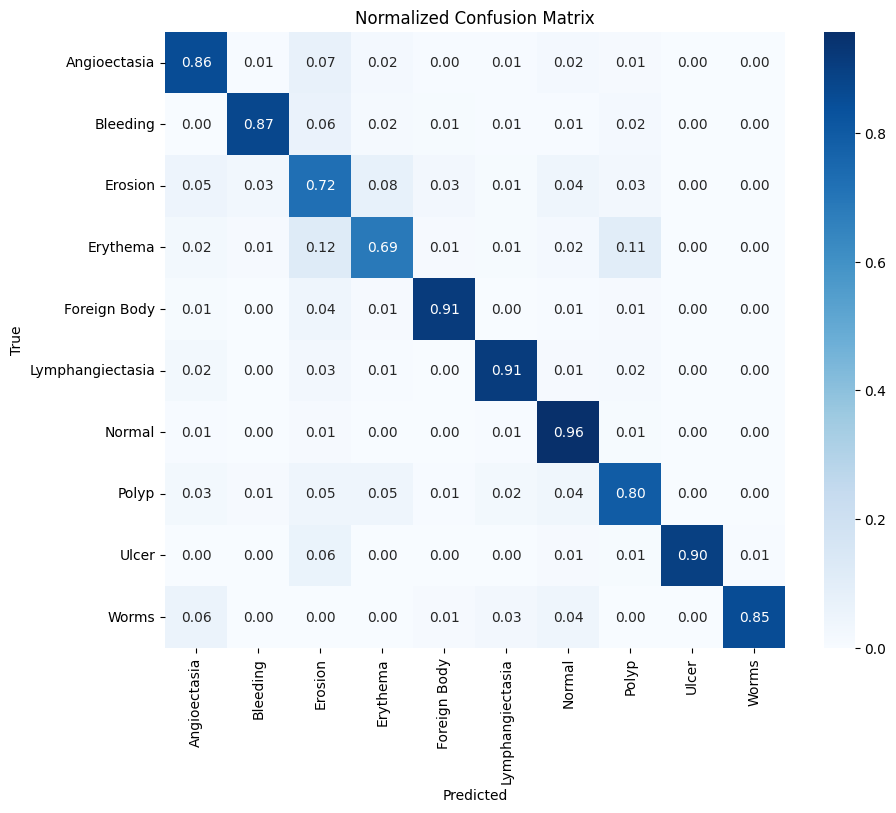

In [19]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

## Plotting AUC-ROC Curve

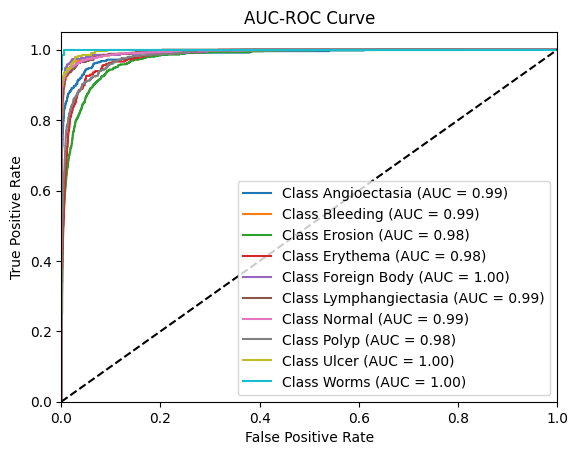

In [20]:
lb = LabelBinarizer()
y_val_bin = lb.fit_transform(y_val_classes)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_val_bin[:, i], y_pred[:, i])

plt.figure()
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc='lower right')
plt.show()

## Check for Test path

In [24]:
import os

# Define the test path
test_path = '/kaggle/input/vce-testing-dataset/Testing set/Images/'

# Check if the test path exists
if os.path.exists(test_path):
    # Count the number of image files in the test directory
    image_filenames = [fname for fname in os.listdir(test_path) if fname.lower().endswith(('jpg'))]
    num_images = len(image_filenames)
    
    print(f"Test path exists. Number of images in the test directory: {num_images}")
else:
    print("Test path does not exist.")


Test path exists. Number of images in the test directory: 4385


## Model Prediction on Test Data and Exporting Results

In [3]:
# Importing necessary libraries and modules
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input 
import pandas as pd
import platform

# Load model (assuming model path is provided)
model_path = '/kaggle/working/my_model.keras'  # Replace with the path to your model
model = load_model(model_path)

# Function to load and preprocess images
def load_and_preprocess_image(full_path, target_size):
    img = load_img(full_path, target_size=target_size)
    img_array = img_to_array(img)
    preprocessed_img = preprocess_input(img_array)  
    return preprocessed_img

# Function to load test data and preprocess it
def load_test_data(test_dir, image_size=(299, 299)):  
    image_filenames = [fname for fname in os.listdir(test_dir) if fname.lower().endswith(('jpg'))]
    X_test = np.array([load_and_preprocess_image(os.path.join(test_dir, fname), image_size) for fname in image_filenames])
    return X_test, image_filenames

# Function to save predictions to an Excel file
def save_predictions_to_excel(image_paths, predictions, output_filename):
    df = pd.DataFrame({'image_path': image_paths})
    class_columns = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 
                     'Foreign Body', 'Lymphangiectasia', 'Normal', 
                     'Polyp', 'Ulcer', 'Worms']
    
    # Create a DataFrame for the prediction probabilities
    predictions_df = pd.DataFrame(predictions, columns=class_columns)
    
    # Determine the predicted class for each image
    predicted_classes = predictions_df.idxmax(axis=1)
    predictions_df['predicted_class'] = predicted_classes
    
    # Combine the paths and predictions into a single DataFrame
    result_df = pd.concat([df, predictions_df], axis=1)
    
    # Save the DataFrame to an Excel file
    result_df.to_excel(output_filename, index=False)
    print(f"Predictions saved to {output_filename}")

# Parameters for the test data
test_path = '/kaggle/input/vce-testing-dataset/Testing set/Images/' 
image_size = (299, 299)  

# Load and evaluate test data
X_test, image_paths = load_test_data(test_path, image_size=image_size)
y_test_pred = model.predict(X_test)

# Save test predictions to an Excel file
output_test_predictions = "CODE MORPHERS.xlsx"
save_predictions_to_excel(image_paths, y_test_pred, output_test_predictions)


138/138 ━━━━━━━━━━━━━━━━━━━━ 38s 205ms/step
Predictions saved to CODE MORPHERS.xlsx
